In [94]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe
import json

import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

import eurostat

plt.style.use('bmh')

In [95]:
m = {
    'M01': 1,
    'M02': 2,
    'M03': 3,
    'M04': 4,
    'M05': 5,
    'M06': 6,
    'M07': 7,
    'M08': 8,
    'M09': 9,
    'M10': 10,
    'M11': 11,
    'M12': 12
}

In [96]:
gdp = eurostat.get_data_df('namq_10_gdp')
gdp = gdp[gdp['geo\\time'].str.match('FI') & gdp['unit'].str.match('CP_MEUR') & gdp['s_adj'].str.match('NSA') & gdp['na_item'].str.match('B1GQ')]
gdp = gdp.drop(gdp.columns[:4], axis=1).dropna(axis=1).iloc[:,::-1]
gdp = gdp.drop(gdp.columns[:list(gdp.columns).index('2000Q1')], axis=1)
gdp.index = ['gdp']
gdp

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
gdp,31770.0,33827.0,34062.0,36783.0,34472.0,36331.0,35933.0,37892.0,34994.0,37641.0,...,55783.0,58896.0,57846.0,61139.0,57243.0,60914.0,59873.0,62526.0,57542.0,57965.0


In [97]:
ue_df = eurostat.get_data_df('tipsun30')
ue_df = ue_df[ue_df['geo\\time'].str.match('FI')]
ue_df = ue_df.drop(ue_df.columns[:5], axis=1).dropna(axis=1)
ue_df = ue_df.drop(ue_df.columns[:list(ue_df.columns).index('2000Q1')], axis=1)
ue_df.index = ['une']
ue_df.head()

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
une,10.5,9.8,9.5,9.4,9.3,9.0,9.1,9.1,9.1,9.1,...,8.3,7.2,7.2,6.7,6.7,6.6,6.8,6.8,6.8,7.7


In [98]:
EMU_conv_df = eurostat.get_data_df('irt_lt_mcby_q')
EMU_conv_df = EMU_conv_df[EMU_conv_df['geo\\time'].str.match('FI')]
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:3], axis=1).iloc[:,::-1].dropna(axis=1)
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:list(EMU_conv_df.columns).index('2000Q1')], axis=1)
EMU_conv_df.index = ['int']
EMU_conv_df.head()

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
int,5.66,5.48,5.47,5.33,4.99,5.22,5.13,4.83,5.16,5.33,...,0.74,0.67,0.58,0.65,0.41,0.21,-0.25,-0.11,-0.14,-0.09


In [101]:
cpi = eurostat.get_data_df('ei_cphi_m')
cpi = cpi[cpi['geo\\time'].str.match('FI') & cpi['indic'].str.match('CP-HI00')]
cpi = cpi.drop(cpi.index[1:])
cpi = cpi.drop(cpi.columns[:4], axis=1).dropna(axis=1).iloc[:, ::-1]
cpi = cpi.drop(cpi.columns[:list(cpi.columns).index('2000M01')], axis=1)
cpi.columns = map(lambda x: f'{x[:4]}-{m[x[4:]]}', cpi.columns)
cpi = cpi.groupby(pd.PeriodIndex(cpi.columns, freq='Q'), axis=1).mean()
cpi.columns = cpi.columns.astype('str')
cpi.index = ['cpi']
i_1 = cpi.iloc[0][0]
for i, v in enumerate(cpi.iloc[0]):
    cpi.iloc[0][i] = v / i_1 - 1
cpi.head()

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4
cpi,0.0,0.013241,0.016717,0.023667,0.026922,0.043991,0.043595,0.047158,0.054373,0.064271,...,0.353378,0.359801,0.357866,0.369347,0.368115,0.372515,0.372295,0.367544,0.373702,0.37555


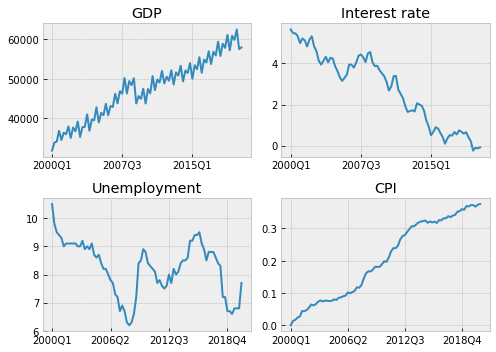

In [102]:
fig, axs = plt.subplots(2,2, figsize=(7,5))
axs[0,0].plot(gdp.iloc[0])
axs[0,0].set_xticks([i for e, i in enumerate(gdp.columns) if e % 30 == 0])
axs[0,0].set_title('GDP')
axs[1,0].plot(ue_df.iloc[0])
axs[1,0].set_title('Unemployment')
axs[1,0].set_xticks([i for e, i in enumerate(ue_df.columns) if e % 25 == 0])
axs[0,1].plot(EMU_conv_df.iloc[0])
axs[0,1].set_title('Interest rate')
axs[0,1].set_xticks([i for e, i in enumerate(EMU_conv_df.columns) if e % 30 == 0])
axs[1,1].plot(cpi.iloc[0])
axs[1,1].set_title('CPI')
axs[1,1].set_xticks([i for e, i in enumerate(cpi.columns) if e % 25 == 0])
fig.tight_layout()

gdp, ue_df, EMU_conv_df, cpi

In [103]:
c_gdp, t_gdp = sm.tsa.filters.hpfilter(gdp.iloc[0], 1600)
c_ue_df, t_ue_df = sm.tsa.filters.hpfilter(ue_df.iloc[0], 1600)
c_EMU_conv_df, t_EMU_conv_df = sm.tsa.filters.hpfilter(EMU_conv_df.iloc[0], 1600)
c_cpi, t_cpi = sm.tsa.filters.hpfilter(cpi.iloc[0], 1600)

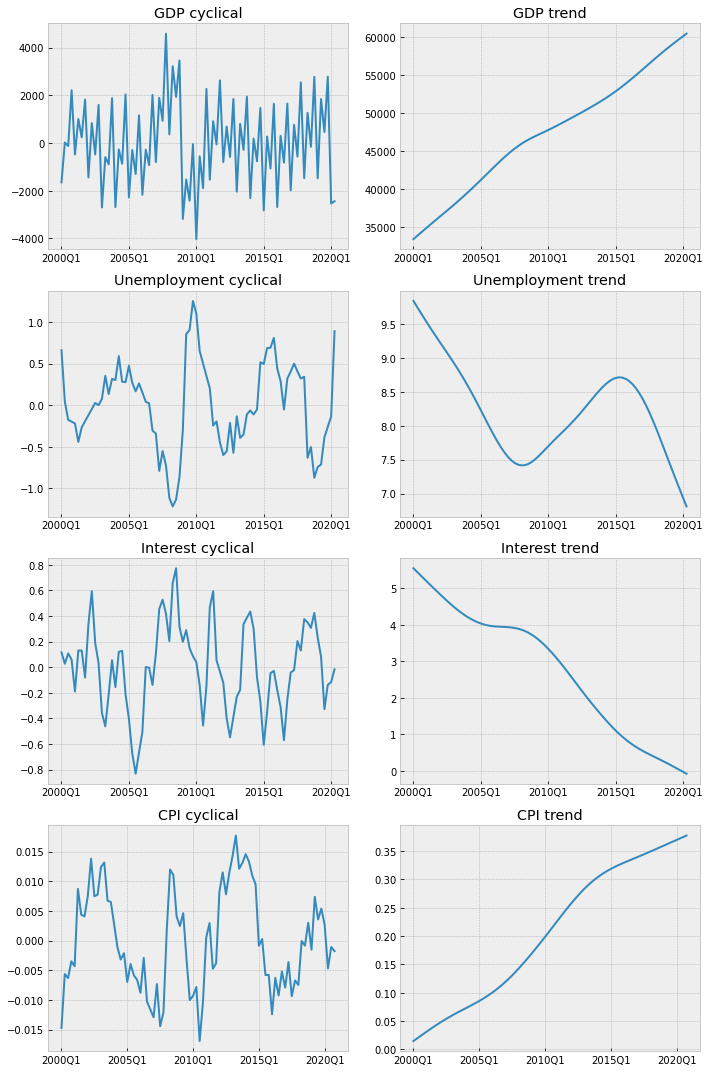

In [104]:
fig, axs = plt.subplots(4,2, figsize=(10,15))

axs[0,0].plot(gdp.columns, c_gdp)
axs[0,0].set_xticks([i for e, i in enumerate(gdp.columns) if e % 20 == 0])
axs[0,1].plot(gdp.columns, t_gdp)
axs[0,1].set_xticks([i for e, i in enumerate(gdp.columns) if e % 20 == 0])
axs[0,0].set_title('GDP cyclical')
axs[0,1].set_title('GDP trend')

axs[1,0].plot(ue_df.columns, c_ue_df)
axs[1,0].set_xticks([i for e, i in enumerate(ue_df.columns) if e % 20 == 0])
axs[1,1].plot(ue_df.columns, t_ue_df)
axs[1,1].set_xticks([i for e, i in enumerate(ue_df.columns) if e % 20 == 0])
axs[1,0].set_title('Unemployment cyclical')
axs[1,1].set_title('Unemployment trend')

axs[2,0].plot(EMU_conv_df.columns, c_EMU_conv_df)
axs[2,0].set_xticks([i for e, i in enumerate(EMU_conv_df.columns) if e % 20 == 0])
axs[2,1].plot(EMU_conv_df.columns, t_EMU_conv_df)
axs[2,1].set_xticks([i for e, i in enumerate(EMU_conv_df.columns) if e % 20 == 0])
axs[2,0].set_title('Interest cyclical')
axs[2,1].set_title('Interest trend')

axs[3,0].plot(cpi.columns, c_cpi)
axs[3,0].set_xticks([i for e, i in enumerate(cpi.columns) if e % 20 == 0])
axs[3,1].plot(cpi.columns, t_cpi)
axs[3,1].set_xticks([i for e, i in enumerate(cpi.columns) if e % 20 == 0])
axs[3,0].set_title('CPI cyclical')
axs[3,1].set_title('CPI trend')

fig.tight_layout()

Slope: 0.16


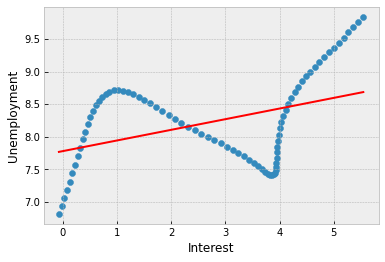

In [105]:
rl = sm.OLS(t_ue_df, sm.add_constant(t_EMU_conv_df)).fit()
a, b = rl.params
print(f'Slope: {b:.2f}')
plt.plot(t_EMU_conv_df, (a + b * t_EMU_conv_df), c='r')
plt.scatter(t_EMU_conv_df, t_ue_df)
plt.xlabel('Interest')
plt.ylabel('Unemployment')
plt.show()

Slope: -2.52


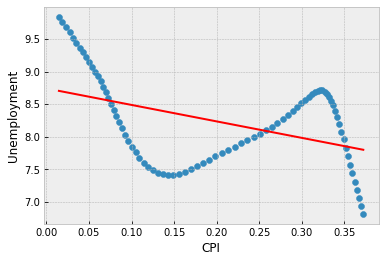

In [106]:
rl = sm.OLS(t_ue_df, sm.add_constant(t_cpi[:-2])).fit()
a, b = rl.params
print(f'Slope: {b:.2f}')
plt.plot(t_cpi[:-2], (a + b * t_cpi[:-2]), c='r')
plt.scatter(t_cpi[:-2], t_ue_df)
plt.xlabel('CPI')
plt.ylabel('Unemployment')
plt.show()

In [107]:
gdp_mean, ue_df_mean, EMU_conv_df_mean, cpi_mean = np.mean(gdp.iloc[0]), np.mean(ue_df.iloc[0]), np.mean(EMU_conv_df.iloc[0]), np.mean(cpi.iloc[0])
cpi_max, cpi_min = max(cpi.iloc[0]), min(cpi.iloc[0])
cpi_grid = np.linspace(cpi_min, cpi_max, num=len(cpi.iloc[0]))

In [108]:
a = abs(min(EMU_conv_df.iloc[0])) + .001
d_ela = sm.OLS(np.log(gdp.iloc[0]), sm.add_constant(np.log(a + EMU_conv_df.iloc[0])) - a).fit()
print(f'Estimated demand elasticity: {d_ela.params[1]}')

Estimated demand elasticity: -0.09234940655228402


Parameters from https://www.aeaweb.org/articles?id=10.1257/aer.101.1.371
Functions from https://notes.quantecon.org/submission/5c4f0f17f68373000f919cd2

In [109]:
@njit
def util(q):    
    return A * (q ** (1 - alpha)) / (1 - alpha)

@njit
def dutil(q):    
    return A * q ** (-alpha)

@njit
def ddutil(q):    
    return (-alpha) * A * q ** (-alpha-1)

@njit
def c(q):
    return G * q ** gamma

@njit
def dc(q):    
    return gamma * G * q ** (gamma - 1)

@njit
def ddc(q):    
    return (gamma - 1) * gamma * G * q ** (gamma - 2)

@njit
def p(theta):    
    return Z * theta ** sigma

@njit
def m(s):    
    return s / (1 + s)

In [110]:
@njit
def g(q):
    return (phi * dutil(q) * c(q) + (1 - phi) * dc(q) * util(q)) / (phi * dutil(q) + (1 - phi) * dc(q))

@njit
def dg(q):  
    up, cp = dutil(q), dc(q)
    upp, cpp = ddutil(q), ddc(q)
    num1 = (up*cp + phi*upp*c(q) + (1-phi)*cpp*util(q)) * (phi*up + (1-phi)*cp)
    num2 = (phi*up*c(q) + (1-phi)*cp*util(q)) * (phi*upp + (1-phi)*cpp)
    den = (phi*up + (1-phi)*cp) ** 2
    d = (num1 - num2) / den
    return d

def q_ss(i, u):
    lw_curve = lambda q: dutil(q) - (1 + (i / (min(m(1 - u),1)))) * dg(q)
    return opt.root(lw_curve, 10 ** (-3), method='lm',options={'ftol': 1e-10}).x

In [111]:
def y_ss(i, u):
    q = q_ss(i,u)    
    return y + min(m(1 - u) / (1 - u),1) * (g(q) - c(q))

@njit
def theta_ss(u):
    return (((1 - u) * delta) / (Z * u)) ** (1 / sigma)

def u_ss(i):
    beveridge_curve = lambda u: k - (min(p(theta_ss(u))/theta_ss(u),1) * eta * (y_ss(i, u) - b)) / (((1 / beta) - 1) + delta + (1 - eta) * min(p(theta_ss(u)),1))
    return opt.root(beveridge_curve, 10 ** (-3), method='lm',options={'ftol': 1e-10}).x

In [113]:
x0 = [u_ss(i)[0] for i in cpi.iloc[0]]
x1 = [(i + 1) ** 4 - 1 for i in cpi_grid]
with open('LTPC.json', 'r') as f:
    d = json.load(f)
    x0 = d['x0']
    x1 = d['x1']

In [114]:
LTPC = {
    'x0': x0,
    'x1': x1
}

with open('LTPC.json', 'w', encoding='utf-8') as f:
    json.dump(LTPC, f, indent=4)

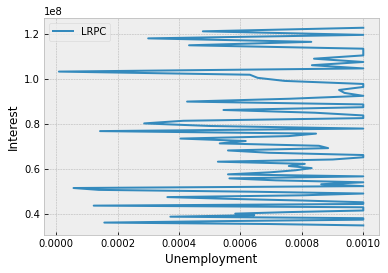

In [115]:
plt.plot(x0, x1, label='LRPC')
plt.xlabel('Unemployment')
plt.ylabel('Interest')
plt.legend(loc='best')
plt.show()
# Should definitely not look like that

In [116]:
def md(i):
    return p(q_ss(i, u_ss(i)) / (4 * (1 - u_ss(i)) * y_ss(i, u_ss(i))))[0]

In [117]:
x0 = [(i + 1) ** 4 - 1 for  i in cpi_grid]
x1 = [md(i) for  i in cpi_grid]

No handles with labels found to put in legend.


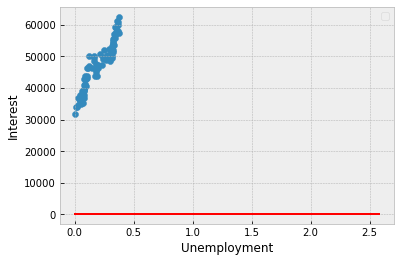

In [118]:
plt.plot(x0, x1, '-r')
plt.scatter(cpi.iloc[0][:-2], gdp.iloc[0])
plt.xlabel('Unemployment')
plt.ylabel('Interest')
plt.legend(loc='best')
plt.show()